# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [5]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import datetime
from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT
from functools import reduce

%matplotlib inline

In [6]:
# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [7]:
# To load the saved models 
from pyspark.ml.tuning import CrossValidatorModel as mlm

In [8]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [9]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Tabulated head through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [11]:
# To know nulls
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [12]:
# Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F', None], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object))

In [13]:
## Dropping records without userids or sessionids
'''
Using the command dfs = df.dropna(how = "any", subset = ["userId", "sessionId"])
We notice from the table above that no records with null userId or SessionId
However, we should check for empty userId or SessionId too
'''

'\nUsing the command dfs = df.dropna(how = "any", subset = ["userId", "sessionId"])\nWe notice from the table above that no records with null userId or SessionId\nHowever, we should check for empty userId or SessionId too\n'

In [14]:
dfp[dfp.userId == '']['userId'].count()

8346

In [15]:
'''
dfp[dfp.sessionId =='']['sessionId'].count()
# Using pandas
dfp[dfp.sessionId == '']
'''

"\ndfp[dfp.sessionId =='']['sessionId'].count()\n# Using pandas\ndfp[dfp.sessionId == '']\n"

In [16]:
# Using Spark commands
df.filter(df.sessionId == '').count()

0

In [17]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')
# Checking if count is zero
df.filter(df.userId == '').count()

0

In [18]:
# redifine the pandas dataframe
dfp = df.toPandas()

In [19]:
# Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F'], dtype=object),
 array(['Logged In', 'Cancelled'], dtype=object))

In [20]:
'''
OBSERVATIONS:
We noticed that the when we cleaned the userId and sessionId, the auth column lost two values 'Logged Out', and 'Guest' and the page column lost some values too which are: 'Login', 'Register', and 'Submit Registration'
This is logical, as the users without a usedId, are either guests or logged out users. Only guests can Register, or Submit Registration, while only logged out users can Login.
'''

"\nOBSERVATIONS:\nWe noticed that the when we cleaned the userId and sessionId, the auth column lost two values 'Logged Out', and 'Guest' and the page column lost some values too which are: 'Login', 'Register', and 'Submit Registration'\nThis is logical, as the users without a usedId, are either guests or logged out users. Only guests can Register, or Submit Registration, while only logged out users can Login.\n"

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [21]:
# Let's know the number of users in this dataset and the number of pages and sessions

[f'Unique {col}s: {df.select(col).dropDuplicates().count()}' for col in ('userId', 'page', 'sessionId')]

['Unique userIds: 225', 'Unique pages: 19', 'Unique sessionIds: 2312']

In [22]:
# How many users in the dataset?
df.select('userId').dropDuplicates().count()

225

In [23]:
'''
CHURN DEFINITION:
Churn is a label for user who cancelled.
'''

'\nCHURN DEFINITION:\nChurn is a label for user who cancelled.\n'

In [24]:
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [25]:
# Again define pandas df for better view
dfp = df.toPandas()

In [26]:
dfp.sample(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
69415,None,Logged In,Lindyn,F,264,Patel,NaN,paid,"Truckee-Grass Valley, CA",PUT,Add to Playlist,1532589384000,224,None,200,1540360302000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,300002,0
191860,La Roux,Logged In,Jayleen,F,31,Reed,205.60934,free,"Riverside-San Bernardino-Ontario, CA",PUT,NextSong,1536019842000,871,Bulletproof,200,1539681407000,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",97,0
16485,JosÃÂ© MercÃÂ©,Logged In,Sadie,F,44,Jones,211.66975,paid,"Denver-Aurora-Lakewood, CO",PUT,NextSong,1537054553000,1569,Sendero,200,1541439590000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",132,0
61412,Britney Spears,Logged In,Jade,F,26,Stewart,197.09342,paid,"Cookeville, TN",PUT,NextSong,1535660231000,331,(You Drive Me) Crazy (The Stop Remix!),200,1541559603000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",300008,0
75105,Cassie,Logged In,Colin,M,188,Larson,214.25587,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,1473,Ditto (Album Version),200,1541073642000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100,0
176889,Angus & Julia Stone,Logged In,Jaxon,M,108,Reilly,268.56444,paid,"Jacksonville, FL",PUT,NextSong,1531760527000,2132,Heart Full Of Wine,200,1543421774000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,86,0
108456,Sting / Mary J. Blige,Logged In,Freedom,F,231,Aguilar,325.11955,paid,"Charlotte-Concord-Gastonia, NC-SC",PUT,NextSong,1537034286000,1063,Whenever I Say Your Name,200,1540110321000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",136,0
38064,None,Logged In,Christian,M,28,Robinson,NaN,free,"Quincy, IL-MO",PUT,Thumbs Up,1534942082000,300,None,307,1538465055000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",87,1
158042,Muse,Logged In,Lina,F,2,Francis,236.22485,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1536948181000,1474,Time Is Running Out,200,1541161636000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,115,0
118746,Metallica,Logged In,Emmanuel,M,235,Smith,515.21261,free,"Hagerstown-Martinsburg, MD-WV",PUT,NextSong,1532364714000,361,Master Of Puppets,200,1543392362000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",200014,0


In [27]:
'''
EXPLORE DATA
'''

'\nEXPLORE DATA\n'

In [28]:
# Know the number of users who still remain and who have cancelled using pandas
dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [29]:
# by spark
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [30]:
# Exploring user status by gender
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [31]:
# Exploring user status by paid lever
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



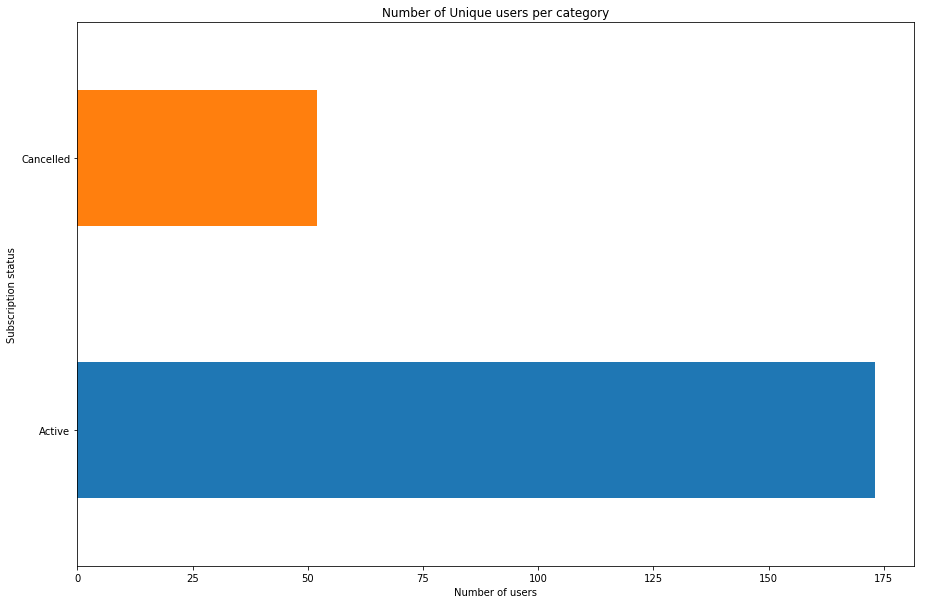

In [32]:
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(15,10), 
                                title='Number of Unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);
# Test    
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

In [33]:
'''
About 25% of the Users cancelled.
'''

'\nAbout 25% of the Users cancelled.\n'

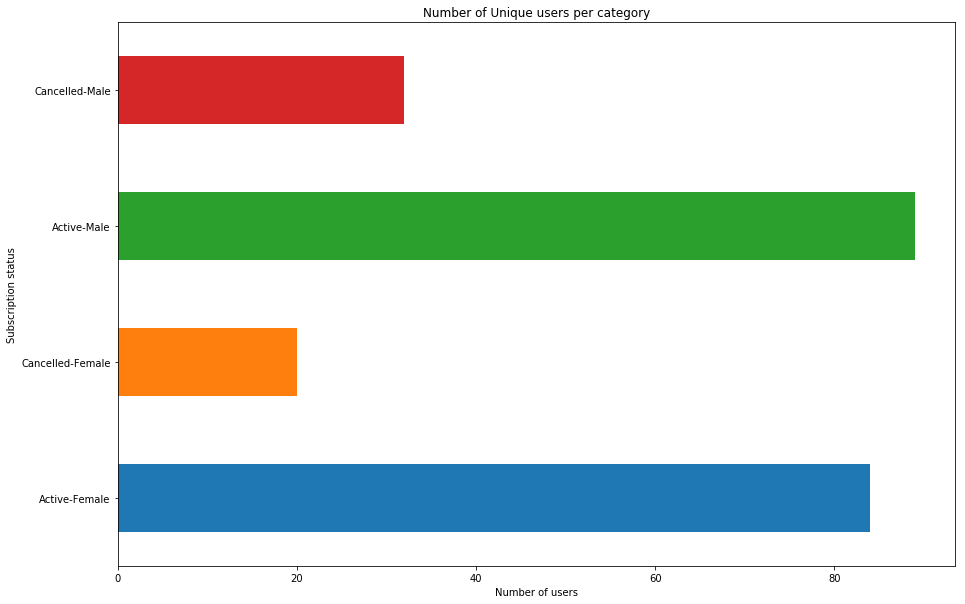

In [34]:
plot_frequency(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

In [35]:
'''
The Active males are more than Females.
Cancelling males are higher than Females. 
Males cancel more than Females.
'''

'\nThe Active males are more than Females.\nCancelling males are higher than Females. \nMales cancel more than Females.\n'

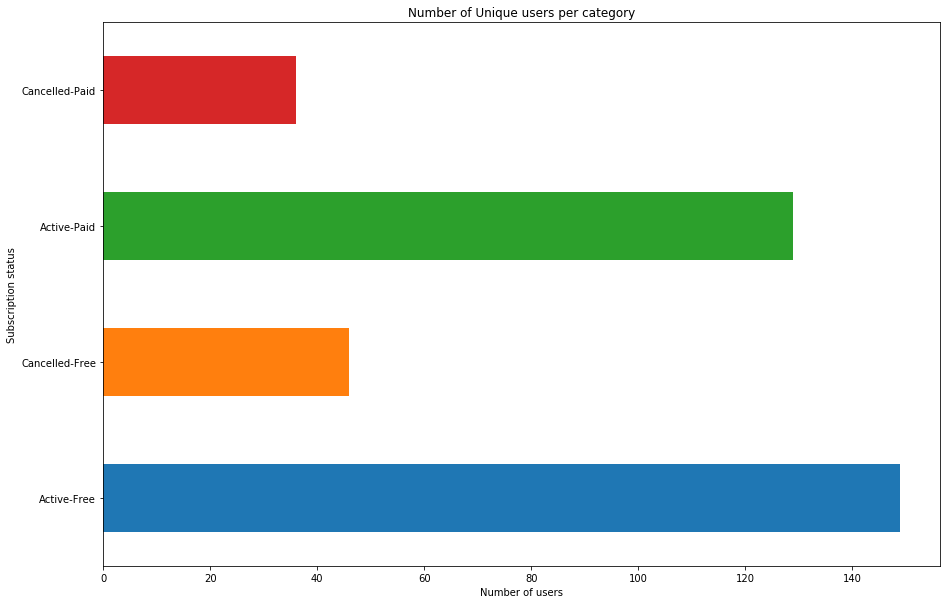

In [36]:
plot_frequency(['userId', 'level'], 
               ['level', 'churn'], 
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

In [37]:
'''
The Free users are slightly more than the Paid users.
Cancelled Free users almost the same ratio as the Cancelled Paid users.
Paid or Free status is not influencing termination of the account.
'''

'\nThe Free users are slightly more than the Paid users.\nCancelled Free users almost the same ratio as the Cancelled Paid users.\nPaid or Free status is not influencing termination of the account.\n'

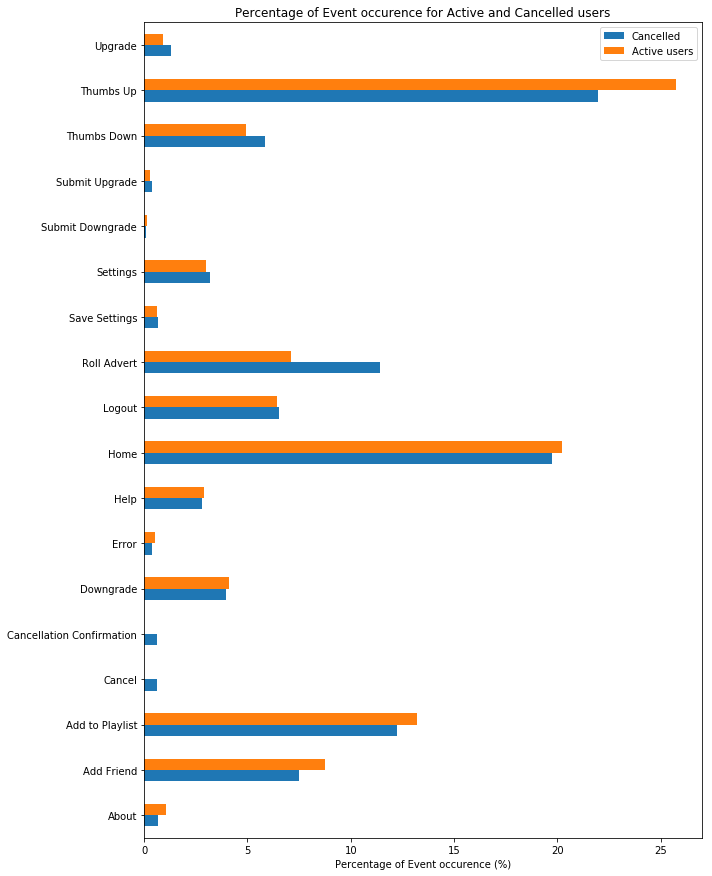

In [38]:
users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100
users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100
users_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(10,15));
ax.set_xlabel('Percentage of Event occurence (%)')
ax.set_title('Percentage of Event occurence for Active and Cancelled users');

In [39]:
 '''
Most important pages visited for cancelling users are Roll Advert, and Thumbs Down.
It is directly proportion to cancelling probability. 
Thumbs Up followed by Add Friend and Add to Playlist are good indicators for not cancelling the account.
 '''

'\nMost important pages visited for cancelling users are Roll Advert, and Thumbs Down.\nIt is directly proportion to cancelling probability. \nThumbs Up followed by Add Friend and Add to Playlist are good indicators for not cancelling the account.\n'

In [40]:
## Time analysis

In [41]:
# Defining user functions to get hour, day, month, and weekday of Cancellation
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [42]:
# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))
    print(f'Column {label} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [43]:
# to help in better plotting and visuals
dfp = df.toPandas()
dfp.sample(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
255019,None,Logged In,Chloe,M,24,Myers,NaN,free,"Tampa-St. Petersburg-Clearwater, FL",GET,...,None,200,1542217168000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",123,0,17,14,11,3
96229,None,Logged In,Logan,M,29,Harper,NaN,free,"Stockton-Lodi, CA",GET,...,None,200,1543506202000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,26,0,15,29,11,4
246694,Sam Cooke,Logged In,Payton,F,36,Campbell,122.04363,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,Ain't Misbehavin,200,1541528288000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39,0,18,6,11,2
44052,Dario Marianelli,Logged In,Jaleel,M,260,Maldonado,258.35057,paid,"Boulder, CO",PUT,...,Elegy For Dunkirk,200,1541443881000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,59,0,18,5,11,1
239622,None,Logged In,Warren,M,89,Miller,NaN,paid,"Baltimore-Columbia-Towson, MD",PUT,...,None,307,1543376307000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4,0,3,28,11,3
228115,Saian Supa Crew,Logged In,Emma,F,36,Allen,226.89914,paid,"Wilson, NC",PUT,...,Angela,200,1540133698000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300021,0,14,21,10,0
150676,Xploding Plastix,Logged In,Calvin,M,54,Marshall,145.55383,paid,"Pittsburgh, PA",PUT,...,Single Stroke Ruffs,200,1542972660000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",38,0,11,23,11,5
46574,Kate Voegele,Logged In,Teagan,F,139,Roberts,222.64118,paid,"New Philadelphia-Dover, OH",PUT,...,One Way Or Another,200,1540841717000,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,28,1,19,29,10,1
105265,Chromatics,Logged In,Joshua,M,197,White,223.47710,paid,"San Antonio-New Braunfels, TX",PUT,...,Night Drive,200,1543553410000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015,0,4,30,11,5
238563,A Fine Frenzy,Logged In,Warren,M,133,Miller,255.60771,paid,"Baltimore-Columbia-Towson, MD",PUT,...,The World Without,200,1541366251000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4,0,21,4,11,0


In [44]:
def get_series(col, churn, normalize=False):
    ''' 
    Get a series either of churn users or existing users
    THe function can normalize the series and return a percent value
    col: {str} the column to plot (hour, month, day, week_day)
    churn: {int} 0 or 1
    normalize: {bool} T/F, Default is False
    return a sorted pandas series
    '''
    ser1 = dfp[dfp.churn == churn].groupby([col])['userId'].count()
    try:
        ser1.index = ser1.index.astype(int)
    except:
        pass
    if normalize:
        ser1=ser1/ser1.sum()*100
    return ser1.sort_index()

In [45]:
def draw_time(col, normalize=True, figsize=(16,4), title=None, label_rotation=0):
    '''
    Draw a bar plot for churn and existing users based on 
         a specific column (hour, month, day, week_day)
         
    normalize: {bool} T/F, Default is True
    figsize: {tuple} the plot size, default is (16,4)
    title: descriptive title part
    Returns: None
    '''
    df_time = pd.DataFrame({'Cancelled': get_series(col, 1, normalize),
                            'Active users':get_series(col, 0, normalize)})
    ax = df_time.plot(kind='bar', figsize=figsize);
    ax.set_ylabel('Percent of users')
    if title is None:
        title = col
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

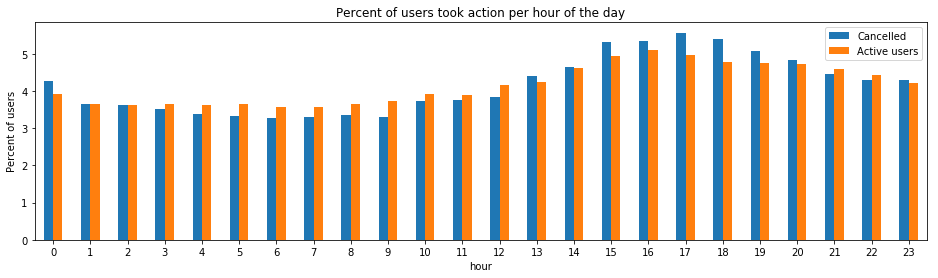

In [46]:
draw_time('hour', title='hour of the day');

In [47]:
'''
No Visual Effect of difference between remaining and cancelling users according to hour of the day. 
The Only Effect is that the Cancelled users are more active on the time between 13:00 to 20:00.
'''

'\nNo Visual Effect of difference between remaining and cancelling users according to hour of the day. \nThe Only Effect is that the Cancelled users are more active on the time between 13:00 to 20:00.\n'

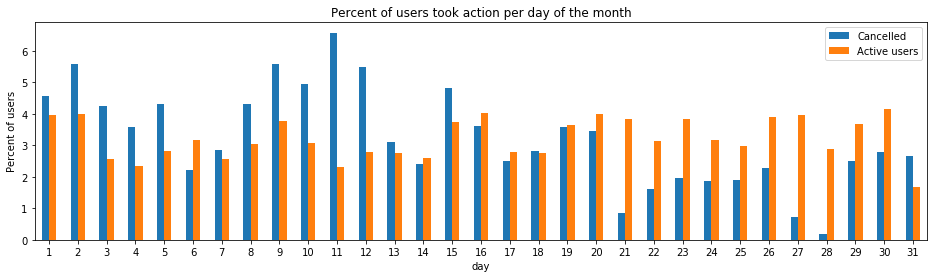

In [48]:
draw_time('day', title='day of the month');

In [49]:
'''
Most Cancellation happens at the end of the month, so as to avoid renewal fees.
'''

'\nMost Cancellation happens at the end of the month, so as to avoid renewal fees.\n'

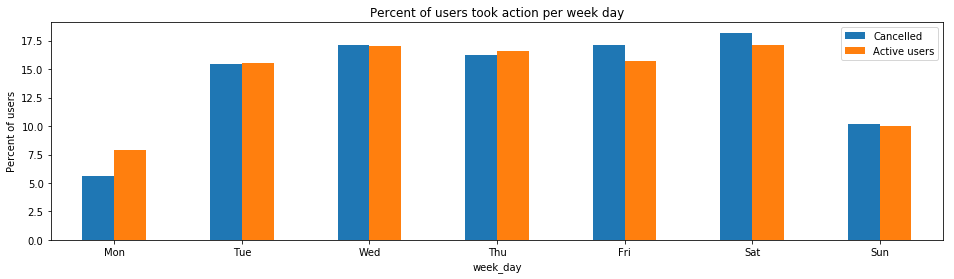

In [50]:
ax = draw_time('week_day', title='week day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0);

In [51]:
'''
On Friday and Saturday, the churn users are more active, while the remaining users are more active Monday. 
The remaining days have no noticable difference between user's types.
'''

"\nOn Friday and Saturday, the churn users are more active, while the remaining users are more active Monday. \nThe remaining days have no noticable difference between user's types.\n"

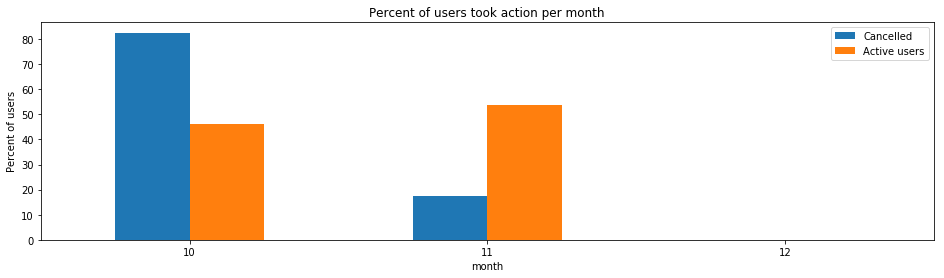

In [52]:
draw_time('month');

In [53]:
'''
Very small data to find any patterns
'''

'\nVery small data to find any patterns\n'

In [54]:
## Categoric features

In [55]:
# Investigating the effect of some other features like the location, State, and userAgent

In [56]:
# User's operating system

In [57]:
dfp.userAgent.unique().shape[0]

56

In [58]:
agents = [x.strip() for x  in dfp.userAgent.unique()] 
# see sample
[agents[x] for x in [0, 2, 4, 10]]

['"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
 '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 '"Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53"']

In [59]:
# To get the data between parenthesis
ex = '\(([^\)]*)\)'

# All Operating Systems
sorted(list(set([re.findall(
    ex, x)[0].split(';')[0].capitalize(
) for x  in agents])))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [64]:
# Create mappers for the os
mapper_general = {'Compatible': 'Windows',  'Ipad': 'Mac',  'Iphone': 'Mac',  
          'Macintosh': 'Mac',  'Windows nt 5.1': 'Windows',  
          'Windows nt 6.0': 'Windows',  'Windows nt 6.1': 'Windows',  
          'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows',  
          'X11': 'Linux'}
mapper_specific = {'Compatible': 'Windows 7',  'Ipad': 'iPad',  'Iphone': 'iPhone',  
          'Macintosh': 'MacOS',  'Windows nt 5.1': 'Windows XP',  
          'Windows nt 6.0': 'Windows Vista',  'Windows nt 6.1': 'Windows 7',  
          'Windows nt 6.2': 'Windows 8.0',  'Windows nt 6.3': 'Windows 8.1',  
          'X11': 'Linux'}


In [66]:
#print(sorted(list(set([mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))),sorted(list(set([mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents])))

In [67]:
# Define user defined functions
os_general = udf(lambda x: mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_general", os_general(df.userAgent))

os_specific = udf(lambda x: mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_specific", os_specific(df.userAgent))

In [68]:
# User's state

In [69]:
dfp.location.unique().shape[0]

114

In [70]:
states = set([state[1].strip() for state in [x.split(',') for x in dfp.location.unique()]])
len(states)

58

In [71]:
# Define a user defined function
get_state = udf(lambda x: x.split(',')[1].strip())
df = df.withColumn("state", get_state(df.location))

In [72]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', day='8', month='10', week_day='1', os_general='Mac', os_specific='iPhone', state='CT')]

In [73]:
# Convert to pandas for better visuals
dfp = df.toPandas()
dfp.sample(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,userAgent,userId,churn,hour,day,month,week_day,os_general,os_specific,state
11958,None,Logged In,Alexi,F,18,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,...,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,1,11,14,10,0,Windows,Windows 7,WA
227730,Nada Surf,Logged In,Emma,F,83,Allen,373.05424,paid,"Wilson, NC",PUT,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300021,0,5,17,10,3,Mac,MacOS,NC
146918,Darius Rucker,Logged In,Faigy,F,230,Howe,208.87465,paid,"Phoenix-Mesa-Scottsdale, AZ",PUT,...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95,0,23,8,10,1,Mac,MacOS,AZ
211497,None,Logged In,Riley,F,82,Stewart,NaN,free,"Los Angeles-Long Beach-Anaheim, CA",GET,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",200006,0,22,12,10,5,Mac,MacOS,CA
111599,Rage Against The Machine,Logged In,Jayden,F,74,Phillips,319.50322,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",118,0,6,26,10,5,Windows,Windows 8.0,NY-NJ-PA
28563,The Verve,Logged In,Kaleb,M,145,Thompson,360.25424,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",29,1,3,9,10,2,Mac,MacOS,CA
271631,None,Logged In,Jayden,M,100,Santos,NaN,free,"Dallas-Fort Worth-Arlington, TX",GET,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",100018,0,19,26,11,1,Mac,MacOS,TX
209666,Starship,Logged In,Destiny,F,83,Herring,290.01098,paid,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",20,0,1,2,11,5,Windows,Windows 7,FL
113029,Sheena Easton,Logged In,Jayden,F,217,Phillips,199.05261,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",118,0,8,25,11,0,Windows,Windows 8.0,NY-NJ-PA
198311,Styx,Logged In,Joshua,M,124,Warner,273.08363,paid,"San Jose-Sunnyvale-Santa Clara, CA",PUT,...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,300025,0,6,30,11,5,Windows,Windows 7,CA


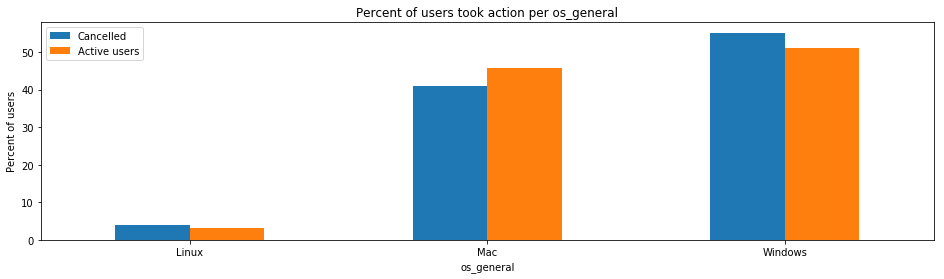

In [74]:
draw_time('os_general');

In [75]:
'''
Mac users are happier than Windows and Linux users.
'''

'\nMac users are happier than Windows and Linux users.\n'

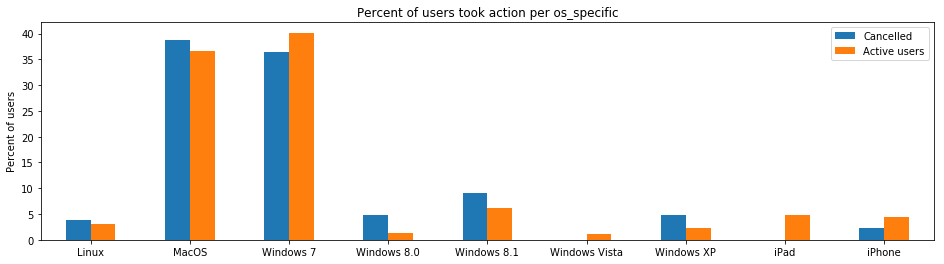

In [76]:
draw_time('os_specific');

In [77]:
'''
The happiest users are the iPad users since there are no Cancellations.
Then follows those of the iPhone and Windows Vista. But Vista users are very small population.
So can't generalize that Vista OS is good (since popular opinion is otherwise :) )
Most users who tend to churn are those who use Windows 8.x, Windows XP, and Linux. 
The above trend could be generalized due to Apple's (iPhone and iPad) good quality service.
'''

"\nThe happiest users are the iPad users since there are no Cancellations.\nThen follows those of the iPhone and Windows Vista. But Vista users are very small population.\nSo can't generalize that Vista OS is good (since popular opinion is otherwise :) )\nMost users who tend to churn are those who use Windows 8.x, Windows XP, and Linux. \nThe above trend could be generalized due to Apple's (iPhone and iPad) good quality service.\n"

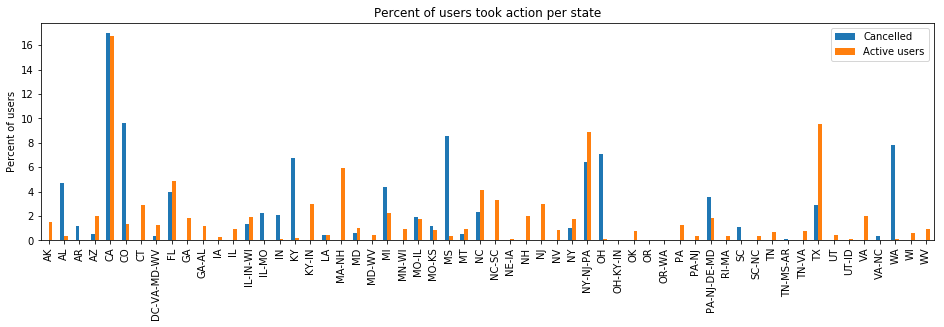

In [78]:
draw_time('state', label_rotation=90);

In [79]:
'''
It appears that some states affects the user behaviour.
'''

'\nIt appears that some states affects the user behaviour.\n'

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [80]:
'''
OVERVIEW:
There are many featurs to keep.

Categoric features (needs to be converted to numeric form through dummi encoding) : 

Gender of user, The user's OS os_specific, (may be) the state he/she lives in, 
The payment level (Paid/Free), (may be) the top artist the user listined to.

Numeric features:

Song length per user per session, Number of ThumbsUp, Number of ThumbsDown, Number of InviteFriends,
Number of downgrades, Number of songs per session, Number of artists the user fans, 
Session's duration, Sessions' count per user, The user's subscription age, 
Number of days as free/paid user
'''

"\nOVERVIEW:\nThere are many featurs to keep.\n\nCategoric features (needs to be converted to numeric form through dummi encoding) : \n\nGender of user, The user's OS os_specific, (may be) the state he/she lives in, \nThe payment level (Paid/Free), (may be) the top artist the user listined to.\n\nNumeric features:\n\nSong length per user per session, Number of ThumbsUp, Number of ThumbsDown, Number of InviteFriends,\nNumber of downgrades, Number of songs per session, Number of artists the user fans, \nSession's duration, Sessions' count per user, The user's subscription age, \nNumber of days as free/paid user\n"

In [81]:
# Create a table of chorn/ not chorn users, as the base of ML dataset

In [82]:
churn_users = df.select('userId', 'churn').dropDuplicates()
# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [83]:
# Getting Dummy variable from the 'gender'
def create_dummy_df (col, dictionary):
    '''
    Create a dataframe to map a variable
    col: the column name
    dictionary: the mapping of from->to numeric values
    return a dataframe of 2 columns
    '''
    # To map M and F to numeric values, we first should map to string numbers (to avoid spark error)
    col_df = df.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    # Then convert the result to numeric value
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check
    print(col_df.printSchema(), col_df.show(3))
    return col_df

gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows

None None


In [84]:
# Getting Dummy variables from a categoric value : 'os_specific'
os_titles =  df.select('os_specific').distinct().rdd.flatMap(lambda x: x).collect()
os_expr = [sF.when(sF.col('os_specific') == osdt, 1).otherwise(0).alias("OS_" + osdt) for osdt in os_titles]
os_df = df.select('userId', *os_expr)
os_df.show(10)

+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|userId|OS_iPad|OS_iPhone|OS_Windows 8.1|OS_Linux|OS_Windows Vista|OS_Windows 8.0|OS_MacOS|OS_Windows XP|OS_Windows 7|
+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       

In [85]:
os_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- OS_iPad: integer (nullable = false)
 |-- OS_iPhone: integer (nullable = false)
 |-- OS_Windows 8.1: integer (nullable = false)
 |-- OS_Linux: integer (nullable = false)
 |-- OS_Windows Vista: integer (nullable = false)
 |-- OS_Windows 8.0: integer (nullable = false)
 |-- OS_MacOS: integer (nullable = false)
 |-- OS_Windows XP: integer (nullable = false)
 |-- OS_Windows 7: integer (nullable = false)



In [86]:
# Getting Dummy variable from the 'level'
level_df = create_dummy_df('level', {'paid':'1', 'free':'0'})

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
+------+-----+
only showing top 3 rows

None None


In [87]:
'''
The state and top_artists will be omitted in this stage.
'''

'\nThe state and top_artists will be omitted in this stage.\n'

In [88]:
# Number of artists in the dataset
dfp.artist.unique().shape[0]

17656

In [89]:
# Song length per user per session (Get mean and StdDev per user)
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(10)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878
5,7,1.509289,1.737257
6,54,5.645595,6.724164
7,15,9.470389,6.159368
8,155,9.202745,6.528672
9,100014,3.134420,1.754365


In [90]:
# Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades.
# To get the Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, ...
# I think it is better to get all actions except Chorn actions (Cancel, cancelation confirmation)
# The to normalize them as percent to sum all to 100.

# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1

# SOURCES
# https://stackoverflow.com/questions/47641076/spark-normalize-each-row-of-a-dataframe
# https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe

# the columns to be summed
pages_cols = user_page_distribution.columns[1:]

# Add a total column
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))

# Apply normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


In [91]:
# Number of songs per session
# 2-F Number of songs per session
# number of changing songs
song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



In [92]:
# Number of artists the user fans
artists_user_fans = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(3)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
+------+----------+
only showing top 3 rows



In [93]:
# Session Duration
# 2-G.1 Session Duration

session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [94]:
# 2-G.2  Get Average, and Standard deviation of the session duration per user

session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
+------+-------------------+------------------+
only showing top 3 rows



In [95]:
# Sessions count per user
# 2-H Sessions count per user
num_sessions_user_df = df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



In [96]:
# The user's subscription age
# 2-I The user's subscription age
def days_since_subscription(df, col_name='days_on'):
    # timestamp of users registration
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



In [97]:
# Number of days as paid user
df_paid = df.filter(df.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(5)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
|    15|    56.513576388888886|
|    54|    110.75168981481481|
+------+----------------------+
only showing top 5 rows



In [98]:
# Number of days as free user
df_free = df.filter(df.level=='free')
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show(5)

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
|     7|     72.77818287037037|
|    54|     96.45179398148149|
+------+----------------------+
only showing top 5 rows



In [99]:
'''
The numbers are inconsistent.
This is because the code considers the minimum TS is the registration day, 
not the minimum day the user status is paid or free. 
The correct calculation could be performed by Window function over the change in status. 
'''

'\nThe numbers are inconsistent.\nThis is because the code considers the minimum TS is the registration day, \nnot the minimum day the user status is paid or free. \nThe correct calculation could be performed by Window function over the change in status. \n'

In [100]:
# Free or Paid songs percent per user
paid_free_df = df.filter(df.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(10)

+------+------------------+-----------------+
|userId|      free_percent|     paid_percent|
+------+------------------+-----------------+
|200002| 22.48062015503876|77.51937984496125|
|100010|             100.0|              0.0|
|   125|             100.0|              0.0|
|     7|             100.0|              0.0|
|   124|               0.0|            100.0|
|    51|               0.0|            100.0|
|    54|15.452305526223162|84.54769447377683|
|    15|               0.0|            100.0|
|   155|12.317073170731707| 87.6829268292683|
|   132|1.4522821576763485|98.54771784232366|
+------+------------------+-----------------+
only showing top 10 rows



In [101]:
'''
It is enough to keep only the paid_percent or the free_percent
'''

'\nIt is enough to keep only the paid_percent or the free_percent\n'

In [102]:
paid_free_df = paid_free_df.drop('free_percent')
paid_free_df.show(3)

+------+-----------------+
|userId|     paid_percent|
+------+-----------------+
|200002|77.51937984496125|
|100010|              0.0|
|   125|              0.0|
+------+-----------------+
only showing top 3 rows



In [103]:
## Collect All

In [104]:
# the features to collect
user_features = [gender_df, os_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df, artists_user_fans, 
                   session_user_df, num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'os_df', 'paid_free_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                   'session_user_df', 'num_sessions_user_df', 'reg_df']

In [106]:
# Initialize the final_df
final_df = churn_users

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)
print('---------COMPLETE----------')

Preparing features of the gender_df dataframe; the new frame's dimensions is: 225 * 3
Preparing features of the os_df dataframe; the new frame's dimensions is: 225 * 12
Preparing features of the paid_free_df dataframe; the new frame's dimensions is: 225 * 13
Preparing features of the song_length dataframe; the new frame's dimensions is: 225 * 15
Preparing features of the user_page_distribution dataframe; the new frame's dimensions is: 225 * 32
Preparing features of the song_user_df dataframe; the new frame's dimensions is: 225 * 34
Preparing features of the artists_user_fans dataframe; the new frame's dimensions is: 225 * 35
Preparing features of the session_user_df dataframe; the new frame's dimensions is: 225 * 37
Preparing features of the num_sessions_user_df dataframe; the new frame's dimensions is: 225 * 38
Preparing features of the reg_df dataframe; the new frame's dimensions is: 225 * 39
---------COMPLETE----------


In [107]:
# Saving the dataframe for future access in another session
# Saving as SPARK format
final_df.write.save('saved_user_dataset.CSV', format='csv', header=True)

In [108]:
# And a pandas dataset as well
final_dfp = final_df.toPandas()
final_dfp.head(10)

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,10,0,1,0,0,0,0,0,0,1,...,0.503145,4.654088,0.000000,112.166667,133.324291,566,7.662454,8.991061,6,51.762650
1,100,0,1,0,0,0,0,0,0,0,...,0.840075,4.604854,0.031114,78.882353,74.057621,1706,5.275317,5.133618,35,64.873773
2,100001,1,0,0,0,0,0,0,0,1,...,1.081081,4.324324,1.081081,33.250000,16.839933,126,2.469306,1.051126,4,44.800220
3,100002,0,0,0,0,0,0,0,0,0,...,0.000000,2.293578,0.000000,48.750000,84.428964,185,3.353056,5.901765,4,160.472072
4,100003,1,0,0,0,0,0,0,0,0,...,0.000000,3.947368,0.000000,25.500000,33.234019,51,1.651944,2.260385,2,22.748113
5,100004,0,0,0,0,0,0,0,0,0,...,0.883534,2.811245,0.642570,47.100000,55.459706,734,3.099775,3.895202,21,172.440081
6,100005,1,1,0,0,0,0,0,0,1,...,1.401869,3.271028,1.869159,38.500000,13.771952,150,2.003111,1.367039,5,85.195590
7,100006,1,0,0,0,1,0,0,0,0,...,4.761905,4.761905,0.000000,26.000000,0.000000,27,1.557222,0.000000,1,9.127164
8,100007,1,0,0,0,1,0,0,0,0,...,1.158301,3.667954,0.000000,47.000000,55.366958,358,3.156852,3.789902,9,115.387616
9,100008,0,0,0,0,0,0,0,0,1,...,0.638298,3.936170,0.425532,128.666667,182.128160,624,8.804213,12.541217,6,68.228565


In [109]:
final_dfp.to_csv('saved_user_dataset_pd.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [110]:
## Loading and adjusting data

final_df = spark.read.csv('saved_user_dataset.CSV', header = True)
pfinal_df = final_df.toPandas()
pfinal_df.head()

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,30,0,1,0,0,0,0,0,0,0,...,0.9577464788732395,3.492957746478873,0.7887323943661971,50.607142857142854,68.92579976333879,1019,3.0599045138888887,4.655638231407505,32,63.06664351851852
1,300001,1,0,0,0,0,0,0,0,0,...,0.7848568790397045,6.832871652816251,0.09233610341643582,102.88235294117646,88.12908313444346,1202,6.367543859649123,6.150871757879998,19,188.3117824074074
2,91,0,1,0,0,1,0,0,0,0,...,0.7962840079628402,4.11413404114134,0.033178500331785,286.6666666666667,337.84426885770904,1619,19.665,23.019357929090734,9,116.02526620370371
3,92,0,0,1,0,0,0,0,0,0,...,0.9958506224066389,4.0387275242047025,0.06915629322268327,70.77380952380952,86.9796197137792,2905,4.745203488372092,6.054084867345142,86,83.52885416666666
4,200008,0,0,0,0,0,0,0,0,0,...,2.584493041749503,3.3797216699801194,0.049701789264413515,111.26666666666667,107.38613016763829,1160,7.5379259259259275,7.284556907097743,15,115.18381944444444


In [111]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- OS_iPad: string (nullable = true)
 |-- OS_iPhone: string (nullable = true)
 |-- OS_Windows 8.1: string (nullable = true)
 |-- OS_Linux: string (nullable = true)
 |-- OS_Windows Vista: string (nullable = true)
 |-- OS_Windows 8.0: string (nullable = true)
 |-- OS_MacOS: string (nullable = true)
 |-- OS_Windows XP: string (nullable = true)
 |-- OS_Windows 7: string (nullable = true)
 |-- paid_percent: string (nullable = true)
 |-- mean_hours: string (nullable = true)
 |-- stdev_hours: string (nullable = true)
 |-- About: string (nullable = true)
 |-- Add Friend: string (nullable = true)
 |-- Add to Playlist: string (nullable = true)
 |-- Downgrade: string (nullable = true)
 |-- Error: string (nullable = true)
 |-- Help: string (nullable = true)
 |-- Home: string (nullable = true)
 |-- Logout: string (nullable = true)
 |-- NextSong: string (nullable = true)
 |-- Roll 

In [112]:
# Change the column names to strings without spaces
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(final_df.columns)

['userId', 'churn', 'gender', 'OS_iPad', 'OS_iPhone', 'OS_Windows_81', 'OS_Linux', 'OS_Windows_Vista', 'OS_Windows_80', 'OS_MacOS', 'OS_Windows_XP', 'OS_Windows_7', 'paid_percent', 'mean_hours', 'stdev_hours', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'num_aritst', 'mean_session_h', 'stdev_session_h', 'num_sessions', 'days_total_subscription']


In [113]:
# Convert all to numbers as the schema shows strings
# the first column (userId) would be integer
final_df = final_df.withColumn('userId', final_df.userId.cast(sT.IntegerType()))
# All columns from Churn to OS_* should be integer types
for col in final_df.columns[1:12]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.IntegerType()))
# All other columns should be float
for col in final_df.columns[12:]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.FloatType()))

final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- OS_iPad: integer (nullable = true)
 |-- OS_iPhone: integer (nullable = true)
 |-- OS_Windows_81: integer (nullable = true)
 |-- OS_Linux: integer (nullable = true)
 |-- OS_Windows_Vista: integer (nullable = true)
 |-- OS_Windows_80: integer (nullable = true)
 |-- OS_MacOS: integer (nullable = true)
 |-- OS_Windows_XP: integer (nullable = true)
 |-- OS_Windows_7: integer (nullable = true)
 |-- paid_percent: float (nullable = true)
 |-- mean_hours: float (nullable = true)
 |-- stdev_hours: float (nullable = true)
 |-- About: float (nullable = true)
 |-- Add_Friend: float (nullable = true)
 |-- Add_to_Playlist: float (nullable = true)
 |-- Downgrade: float (nullable = true)
 |-- Error: float (nullable = true)
 |-- Help: float (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll_Ad

In [114]:
# Remove  nulls from anywhere replacing them by zeros
final_df = final_df.na.fill(0)

In [115]:
# Get features labels for plotting purposes
features_labels = final_df.columns[2:]

In [116]:
# The input features are all but the userId and the Churn
# The output is Churn only

# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')

# Apply the vectorization on the dataset
input_data = features_vector.transform(final_df)
# input_data.show(1)

In [117]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [118]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [119]:
# Defining training and testing samples
train, test = ml_data.randomSplit([0.80, 0.20], seed=179)
# train.show(3), test.show(3)

In [120]:
'''
Defining important Functions for Outputs and Analysis
'''

'\nDefining important Functions for Outputs and Analysis\n'

In [121]:
def format_duration (t_dif):
    t_s = t_dif.seconds
    duration = {}
    duration['h'], rem = divmod(t_s, 3600) 
    duration['m'], duration['s'] = divmod(rem, 60)
    stamp = ''
    if duration['h']>0:
        stamp += f"{duration['h']} hour(s), " 
    if duration['m']>0:
        stamp += f"{duration['m']} minute(s) and "
    # seconds and fraction of seconds
    frac = int(t_dif.microseconds/10000)/100
    stamp += f"{duration['s'] + frac} second(s)"
    # print(f"{duration['h']}h:{duration['m']}m:{duration['s']}s")
    return stamp

In [122]:
def model_fitting(data, model_type, param_grid, save_as, num_folds=3, random_seed=179):
    '''
    
    
    '''
    model_evaluator = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=num_folds, seed=random_seed)
    t_start = pd.tslib.Timestamp.now()
    print ('Fitting in progress...', end=' ')
    fitted_model = model_evaluator.fit(data)
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    t_start = pd.tslib.Timestamp.now()
    print (f'\nSaving the model as {save_as}...' , end=' ')
    try:
        fitted_model.save(save_as)
    except:
        # Overwrite if exists
        fitted_model.write().overwrite().save(save_as)
        print ('*Overwritten* ', end='')
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    return fitted_model

In [123]:
def get_formated_metrics(selected_model, test_data):
    '''
    Prints a compacted dataframe with all the model's metrics
    selected_model: The fitted model
    test_data: the test data portion
    '''
    def get_model_metrics(selected_model, model_type = 'train'):
        '''
        Get the metrics of a model
        selected_model:  the fitted model
        model_type: either 'train' (default) or 'test'
        '''
        if model_type == 'train':
            metrics = selected_model.bestModel.summary
        else: 
            metrics = selected_model
        acc = metrics.accuracy, 
        general = np.array((metrics.weightedFMeasure(),
                   metrics.weightedPrecision, metrics.weightedRecall,
                   metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate))
        general = general.reshape(1, general.shape[0])
        labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
        labeled = np.array((metrics.fMeasureByLabel(),
                          metrics.precisionByLabel, metrics.recallByLabel,
                          metrics.truePositiveRateByLabel, metrics.falsePositiveRateByLabel))
        conc_results = np.concatenate((general.T, labeled), axis=1)
        metrics_names = ['F-Measure', 'Precision', 'Recall', 'True_+ve_Rate', 'False_+ve_Rate']
        df_res = pd.DataFrame(conc_results, columns=labels, index=metrics_names)
        return acc[0], df_res
    
    # Apply for training data
    acc_train, train_res = get_model_metrics(selected_model)
    # Get the results of the test data
    model_test = selected_model.bestModel.evaluate(test_data)
    # Apply on test data
    acc_test, test_res = get_model_metrics(model_test, model_type='test')
    
    # Concatenate to a pretty dataframe
    pretty_frame = pd.concat([train_res, test_res], axis=1, keys=[
                    f'Training (Accuracy = {acc_train*100:4.2f}%)',
                    f'Testing (Accuracy = {acc_test*100:4.2f}%)'])
    return pretty_frame

In [124]:
def draw_features_contribution(fitted_model, x_labels, scale_to='full_range'):
    '''
    Draws a bar chart of features vs churn %
    fitted_model: the fitted model
    scale_to: the values will be scated to:
           'full_range' where the full absolute values are summed to 100.
           'maximum_range' where the maximum absolute extremes are scalled to 100.
           'none' the values are shown as is.
    '''
    cmx = fitted_model.bestModel.coefficientMatrix
    cmv = cmx.values
    # cmv.shape, len(final_df.columns[2:])
    
    # Define positive and negative values
    positives_v = np.array([x if x>=0 else 0 for x in cmv])
    negatives_v = np.array([x if x<=0 else 0 for x in cmv])    
    
    # Drawing by scalling the maximum range to  100
    if scale_to == 'full_range':
        rang = positives_v.sum()+ abs(negatives_v).sum()
    elif scale_to == 'maximum_range':
        rang = positives_v.max()+ abs(negatives_v).max()
    else:
        rang = 1.
        
    positives_v /= rang
    negatives_v /= rang
    positives_v *= 100.
    negatives_v *= 100.
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(x_labels, positives_v,color='r')
    ax.bar(x_labels, negatives_v, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('The user is most likely to churn (%)')
    ax.set_title('Contribution of each feature to the churn decission')
    ax.set_xticklabels(labels = final_df.columns[2:], rotation='vertical');

In [125]:
def get_classifier_metrics(trained_model, train_data, test_data):
    '''
    
    '''
    def get_specific_metrics(trained_model, data):
        '''
        
        '''
        res2 = trained_model.transform(data).select('label', 'prediction')
        TruePos = res2.filter((res2.prediction==1)& (res2.label == res2.prediction) ).count()
        TrueNeg = res2.filter((res2.prediction==0)& (res2.label == res2.prediction) ).count()
        FalsPos = res2.filter((res2.prediction==1)& (res2.label != res2.prediction) ).count()
        FalsNeg = res2.filter((res2.prediction==0)& (res2.label != res2.prediction) ).count()
        accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = TruePos/(TruePos+FalsPos)
        recall = TruePos/(TruePos+FalsNeg)
        f1score = 2 * precision * recall / (precision + recall)
        return accuracy, precision, recall, f1score
    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels =['Train', 'Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

In [126]:
def draw_features_importance(fitted_model, x_labels, threshold=0.1):
    '''
    Draws a pie chart of features
    fitted_model: the fitted model
    x_labels: the labels of the features.
    threshold: the minimum value (%) to consider, 
               if the value is less than that, 
               it will be neglected (default =0)
    '''
    importance = list(fitted_model.bestModel.featureImportances.toArray())
    # Get the threshold value
    thres_v = threshold / 100 
    # get the included and neglected values
    active_values = [x for x in importance if x >= thres_v]
    neglected = [x for x in importance if x < thres_v]
    non_zero_neglected = [x for x in neglected if x > 0]
    # print(importance, '\n', x_labels, '\n', thres_v, '\n', 
    #       active_values, '\n', neglected, '\n', non_zero_neglected)
    # get the accepted indexes
    active_idx = [importance.index(x) for x in active_values]
    # the accepted lables + minor features
    active_labels = [x_labels[x] for x in active_idx]
    minor_v = sum(neglected)
    # print(active_idx, '\n', active_labels, '\n', minor_v)
    # If there is any minor features
    if minor_v>0:
        active_values.append(minor_v)
        active_labels.append(f'MINOR, ({len( \
                non_zero_neglected)}feats. each<{threshold}%)')
    # print(active_labels, '\n', active_values)
    
    # sorting
    active_labels =[x for _, x in sorted(zip(active_values, active_labels))]
    active_values = sorted(active_values)
    
    # Draw

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(active_values[::-1], labels=active_labels[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90 )
    ax.set_title('Importance of each feature to the churn decission')
    ax.axis('equal');

In [127]:
## LOGISTIC REGRESSION MODEL

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if __name__ == '__main__':


Fitting in progress... Done in 2 minute(s) and 44.99 second(s)

Saving the model as LogisticRegression.model... Done in 1.99 second(s)


Training (Accuracy = 82.49%)                      \
                                    General Churn=0.0 Churn=1.0   
F-Measure                          0.801271  0.895623  0.456140   
Precision                          0.807945  0.841772  0.684211   
Recall                             0.824859  0.956835  0.342105   
True_+ve_Rate                      0.824859  0.956835  0.342105   
False_+ve_Rate                     0.525919  0.657895  0.043165   

               Testing (Accuracy = 77.08%)                      
                                   General Churn=0.0 Churn=1.0  
F-Measure                         0.743333  0.853333  0.476190  
Precision                         0.761179  0.780488  0.714286  
Recall                            0.770833  0.941176  0.357143  
True_+ve_Rate                     0.770833  0.941176  0.357143  
False_+ve_Rate                    0.472514  0.642857  0.058824

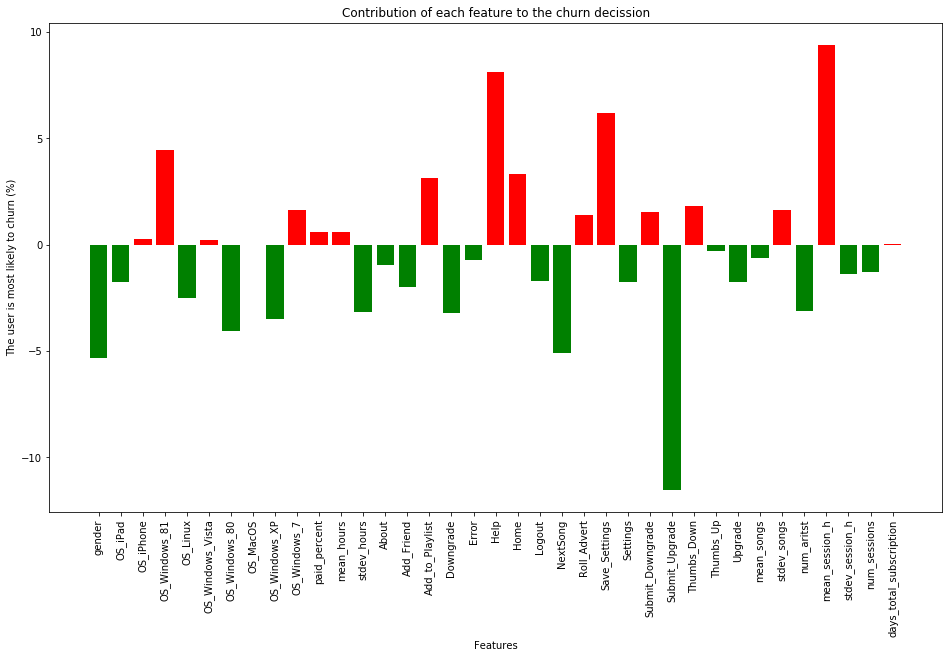

In [128]:
model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()
# param_grid = ParamGridBuilder() \
#     .addGrid(model.aggregationDepth,[2, 5]) \
#     .build()
m = model_fitting(train, model, param_grid, 'LogisticRegression.model')
# Model metrics
display(get_formated_metrics(m, test))
# Features effect
draw_features_contribution(m, x_labels=features_labels)

In [129]:
## DECISION TREE CLASSIFIER MODEL

In [130]:
model = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .build()

m = model_fitting(train, model, param_grid, 'DecisionTreeClassifier.model')

Fitting in progress... Done in 42.38 second(s)

Saving the model as DecisionTreeClassifier.model... Done in 1.23 second(s)


In [131]:
# Uncomment if you want to load models only
features_labels = ['gender', 'OS_iPad', 'OS_iPhone', 'OS_Windows_81', 
                   'OS_Linux', 'OS_Windows_Vista', 'OS_Windows_80', 
                   'OS_MacOS', 'OS_Windows_XP', 'OS_Windows_7', 
                   'paid_percent', 'mean_hours', 'stdev_hours', 
                   'About', 'Add_Friend', 'Add_to_Playlist', 
                   'Downgrade', 'Error', 'Help', 'Home', 'Logout', 
                   'NextSong', 'Roll_Advert', 'Save_Settings', 
                   'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 
                   'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 
                   'stdev_songs', 'num_aritst', 'mean_session_h', 
                   'stdev_session_h', 'num_sessions', 
                   'days_total_subscription']
len(features_labels)

37

In [132]:
# to load the model from saved location
m = mlm.load('DecisionTreeClassifier.model')

In [133]:
get_classifier_metrics(m, train, test)

,Train,Test
Accuracy,0.903955,0.812500
Precision,0.838710,0.727273
Recall,0.684211,0.571429
F-Score,0.753623,0.640000


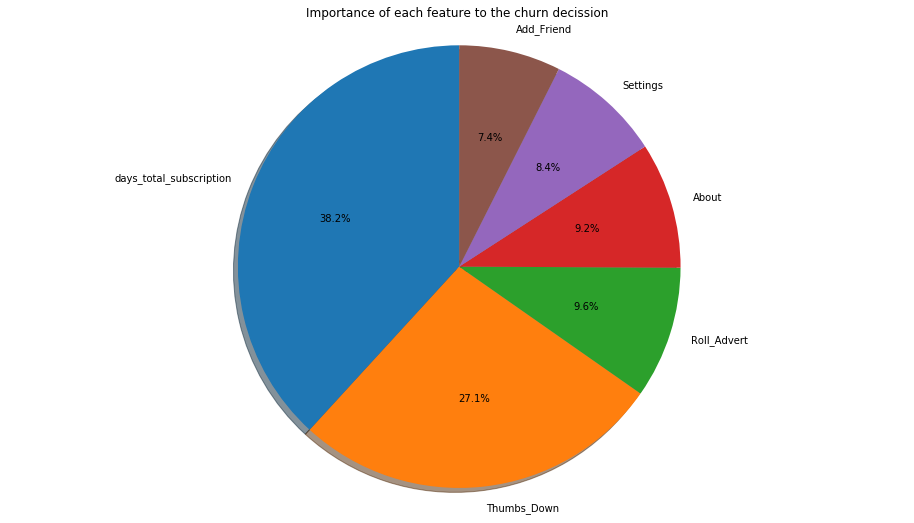

In [134]:
draw_features_importance(m, features_labels, threshold=3)

In [135]:
## GRADIENT-BOOSTED TREE MODEL

In [136]:
model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.maxIter ,[20, 5]) \
    .build()

m = model_fitting(train, model, param_grid, 'GradientBoostedTrees.model')

Fitting in progress... Done in 8 minute(s) and 2.54 second(s)

Saving the model as GradientBoostedTrees.model... Done in 1.71 second(s)


In [137]:
# to load the model from saved location
m = mlm.load('GradientBoostedTrees.model')

In [138]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.920904,0.770833
Precision,0.961538,0.666667
Recall,0.657895,0.428571
F-Score,0.781250,0.521739


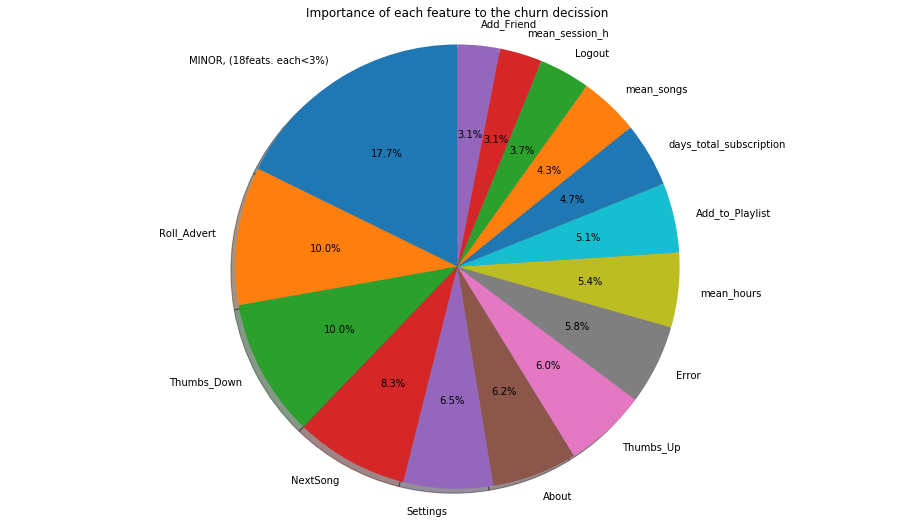

In [139]:
draw_features_importance(m, features_labels, threshold=3)

In [140]:
## RANDOM FOREST CLASSIFIER MODEL

In [141]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.numTrees ,[20, 10]) \
    .addGrid(model.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

m = model_fitting(train, model, param_grid, 'RandomForestClassifier.model')

Fitting in progress... Done in 3 minute(s) and 27.03 second(s)

Saving the model as RandomForestClassifier.model... Done in 1.17 second(s)


In [142]:
# to load the model from saved location
m = mlm.load('RandomForestClassifier.model') 

In [143]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.937853,0.812500
Precision,1.000000,0.857143
Recall,0.710526,0.428571
F-Score,0.830769,0.571429


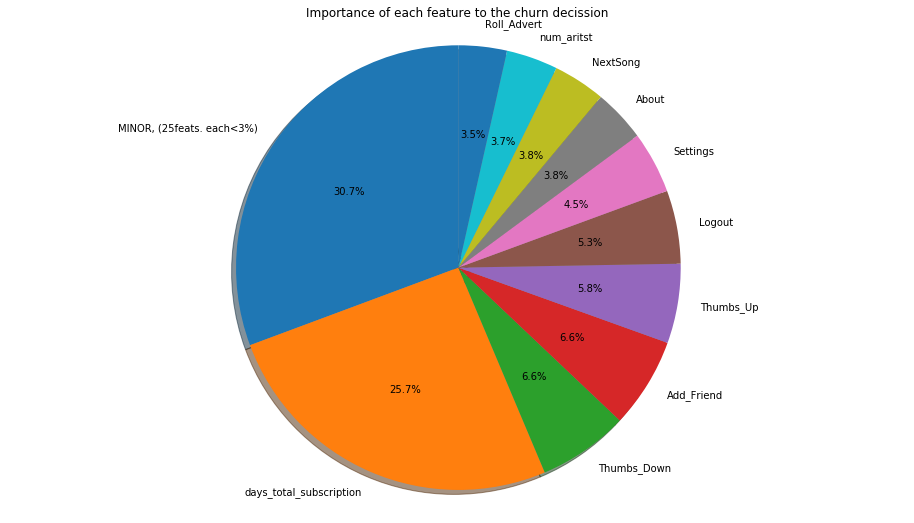

In [144]:
draw_features_importance(m, features_labels, threshold=3)

In [145]:
## MULTI-LAYER PERCEPTRON CLASSIFIER MODEL

In [146]:
model = MultilayerPerceptronClassifier()

param_grid = ParamGridBuilder() \
    .addGrid(model.blockSize,[64, 128]) \
    .addGrid(model.maxIter,[10, 20]) \
    .addGrid(model.stepSize ,[0.03, 0.01]) \
    .addGrid(model.solver ,['l-bfgs', 'gd']) \
    .addGrid(model.layers, [[37, 12, 2], [37, 5, 2]]) \
    .build()

m = model_fitting(train, model, param_grid, 'MultilayerPerceptronClassifier.model')

Fitting in progress... Done in 3 minute(s) and 48.77 second(s)

Saving the model as MultilayerPerceptronClassifier.model... Done in 0.79 second(s)


In [147]:
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.960452,0.770833
Precision,0.878049,0.636364
Recall,0.947368,0.500000
F-Score,0.911392,0.560000


In [148]:
'''
Multi-layer Perceptron Classification Model has no attribute 'featureImportances'. 
So can't visualize, so not good option.
'''

"\nMulti-layer Perceptron Classification Model has no attribute 'featureImportances'. \nSo can't visualize, so not good option.\n"

In [149]:
## NAIVEBAYES MODEL

In [150]:
'''
Naive Bayes requires nonnegative feature values but the features vector contains negative values.
NOT SUITABLE DUE TO NATURE OF THE DATA.
'''

'\nNaive Bayes requires nonnegative feature values but the features vector contains negative values.\nNOT SUITABLE DUE TO NATURE OF THE DATA.\n'

In [151]:
'''
GENERALIZATION OF THIS ANALYSIS
'''

'\nGENERALIZATION OF THIS ANALYSIS\n'

In [152]:
'''
The important functions are present in "Spark_Projects_Essentials.py". 
So, the analysis could be applied to different dataset on other cloud sites.
'''

'\nThe important functions are present in "Spark_Projects_Essentials.py". \nSo, the analysis could be applied to different dataset on other cloud sites.\n'

In [156]:
from Spark_Projects_Essentials import load_clean_transfer

In [157]:
# Assume we have new_data.json
load_clean_transfer('new_data.json', save_as='new_dat_extraction')

In [158]:
'''
The above function load_clean_transfer can read the data from the given source, clean the data and 
save the cleaned dataset to the new name as new_dat_extraction.CSV
'''

'\nThe above function load_clean_transfer can read the data from the given source, clean the data and \nsave the cleaned dataset to the new name as new_dat_extraction.CSV\n'

In [159]:
from Spark_Projects_Essentials import load_ml_dataset, get_train_test_features, apply_model

In [160]:
# load the saved extracted data new_dat_extraction.CSV
ml_ds = load_ml_dataset(saved_as='new_dat_extraction.CSV')

In [162]:
# get the train, test portions and the features names
train, test, features_labels = get_train_test_features(ml_ds)

In [164]:
# apply an ML model to the data

# Either by creating the model:

apply_model(train, test, features_labels, model_name='GBT',save_as='NewGBT.model')

# Or by loading existing model Eg)

apply_model(train, test, features_labels,model_name='LR', load_from_existing='LogisticRegression.model')


In [165]:
'''
CONCLUSION:

The machine learning modeling succeeded in predicting the customers' activity that will most probably 
end in unsubscribing. Despite the good results of all the models, the Decision Tree Classifier model 
appears to be the best here. 
However, the other models need to be re-adjusted using different settings to reduce the overfitting.

Ways to improve:
Working with more observations by increasing the dataset size 
Trying more parameters of the selected models.
Adding some more essential features, such as the customer location (city/state). 
'''

"\nCONCLUSION:\n\nThe machine learning modeling succeeded in predicting the customers' activity that will most probably \nend in unsubscribing. Despite the good results of all the models, the Decision Tree Classifier model \nappears to be the best here. \nHowever, the other models need to be re-adjusted using different settings to reduce the overfitting.\n\nWays to improve:\nWorking with more observations by increasing the dataset size \nTrying more parameters of the selected models.\nAdding some more essential features, such as the customer location (city/state). \n"

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.